# Convolutional Autoencoder and Anomaly Detection
## Learning Objectives
1. Learn how to build a Deep Convolutional Autoencoder
2. Learn how to use a trained Autoencoder for anomaly detection

In this lab, you will learn how to build an autoencoder model. Autoencoder is a popular unsupervised model which consists of encoder and decoder.<br>
There are various type of the useage of it, but in this lab we will use autoencoder for anomaly detection.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)

### Load MNIST Data

Use Keras utilities to load MNIST data. MNIST dataset are handwritten digit image dataset, and each data has shape of (28, 28, 1). 


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

## Build Autoencoder model
Let's start building an Autoencoder model. 

Autoencoder is a self-supervised model it uses the same feature for input and label. 

![image](https://user-images.githubusercontent.com/6895245/164359926-f72472ca-f2de-4098-bf2b-3e649749f721.png)

It try to embed inputs in a fixed sized lattent space (encoder), and try to 'reconstruct' the input from the embedding (decoder).

### Encoder
Let's build the encoder part at first. Encoder goes from the inputs to the latent dim.
![image](https://user-images.githubusercontent.com/6895245/164373070-f7860451-1720-4e4b-aa91-460c4aa98020.png)


In [3]:
latent_dim = 2  # for easy visualization
WIDTH, HEIGHT, CHANNEL = (28, 28, 1)  # Size of input data

encoder = tf.keras.Sequential(
    [
        keras.Input(shape=(WIDTH, HEIGHT, CHANNEL), name="image_input"),
        layers.Conv2D(
            32,
            3,
            activation="relu",
            strides=2,
            padding="same",
            name="encoder_convolution_1",
        ),
        layers.Conv2D(
            64,
            3,
            activation="relu",
            strides=2,
            padding="same",
            name="encoder_convolution_2",
        ),
        layers.Flatten(name="encoder_flatten"),
        layers.Dense(latent_dim, name="encoder_dense"),
    ],
    name="encoder",
)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_convolution_1 (Conv2 (None, 14, 14, 32)        320       
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 7, 7, 64)          18496     
_________________________________________________________________
encoder_flatten (Flatten)    (None, 3136)              0         
_________________________________________________________________
encoder_dense (Dense)        (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


2022-04-21 04:38:32.316311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 04:38:32.330179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 04:38:32.330843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 04:38:32.332150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Decoder
The decoder goes from the latent dim back to the reconstructed image.
In order to reconstruct the original shape (28,28,1), we use [`Conv3DTranspose` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (a.k.a Deconvolution).

![image](https://user-images.githubusercontent.com/6895245/164372979-29797db4-d108-4955-8056-ec668465c3f4.png)


In [4]:
decoder = tf.keras.Sequential(
    [
        keras.Input(shape=(latent_dim,), name="decoder_input"),
        layers.Dense(7 * 7 * 64, activation="relu", name="decoder_dense"),
        layers.Reshape((7, 7, 64), name="decoder_reshape"),
        layers.Conv2DTranspose(
            32,
            3,
            activation="relu",
            strides=2,
            padding="same",
            name="decoder_deconvolution_1",
        ),
        layers.Conv2DTranspose(
            1,
            3,
            activation="sigmoid",
            strides=2,
            padding="same",
            name="decoder_deconvolution_2",
        ),
    ],
    name="decoder",
)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_dense (Dense)        (None, 3136)              9408      
_________________________________________________________________
decoder_reshape (Reshape)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_deconvolution_1 (Con (None, 14, 14, 32)        18464     
_________________________________________________________________
decoder_deconvolution_2 (Con (None, 28, 28, 1)         289       
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


### Construct entire autoencoder

The autoencoder consists of the encoder and the decoder blocks. Let's simply stack these two and build the entire autoencoder model.

In [5]:
autoencoder = tf.keras.Sequential(
    [keras.Input(shape=(28, 28, 1), name="image_input"), encoder, decoder],
    name="autoencoder",
)

autoencoder.build()
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2)                 25090     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         28161     
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


### Reconstruction Loss

The optimization goal of the autoencoder is to minimize the error between input and output. So let's chose MSE as the loss function.

In [6]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

## Train autoencoder
Let's run the training by calling `.fit()`.
Here, please notice that both feature and label are the same image data shaped (28, 28, 1).

In [7]:
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

2022-04-21 04:38:33.651987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-21 04:38:34.664728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


547/547 [==============================] - 5s 4ms/step - loss: 0.0701
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0527
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0501
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0483
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0467
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0456
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0449
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0444
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0439
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0435
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0432
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0429
Epoch 13/30
547/547 [===============

## Visualize the latent space

We trained an autoencoder model with `latent_space=2`. Let's visualize the 2 dimensional latent space (output of encoder), and see how it found the pattern from input data.

Notice that label is utilized here just for visualization purpose, but Autoencoder model itself is an unsupervised model and it doesn't use labels.

In [8]:
def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
        z_mean, _, _ = encoder.predict(data)
    else:
        z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

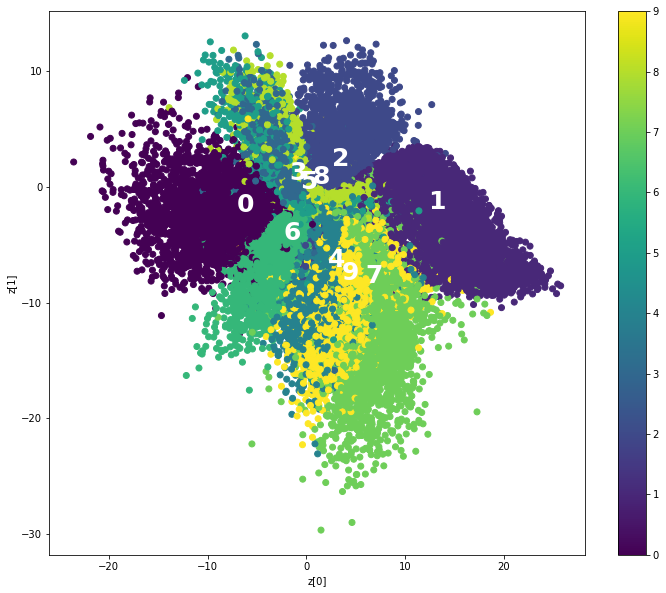

In [9]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=False)

We can see clusters of digits! That means our encoder part found some patern and embedded information in this 2 dimensional latent space.

## Visualize the decoder part 
Now let's take a look at the decoder part as well.
This utility function pass 2 data (`grid_x` and `grid_y`) in specified range to decoder and plot the output of the decoder model.

You can change the range in `[x_min, x_max, y_min, y_max]` format following the range of the cluster above, and check how decoder reconstruct data from latent space

In [10]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

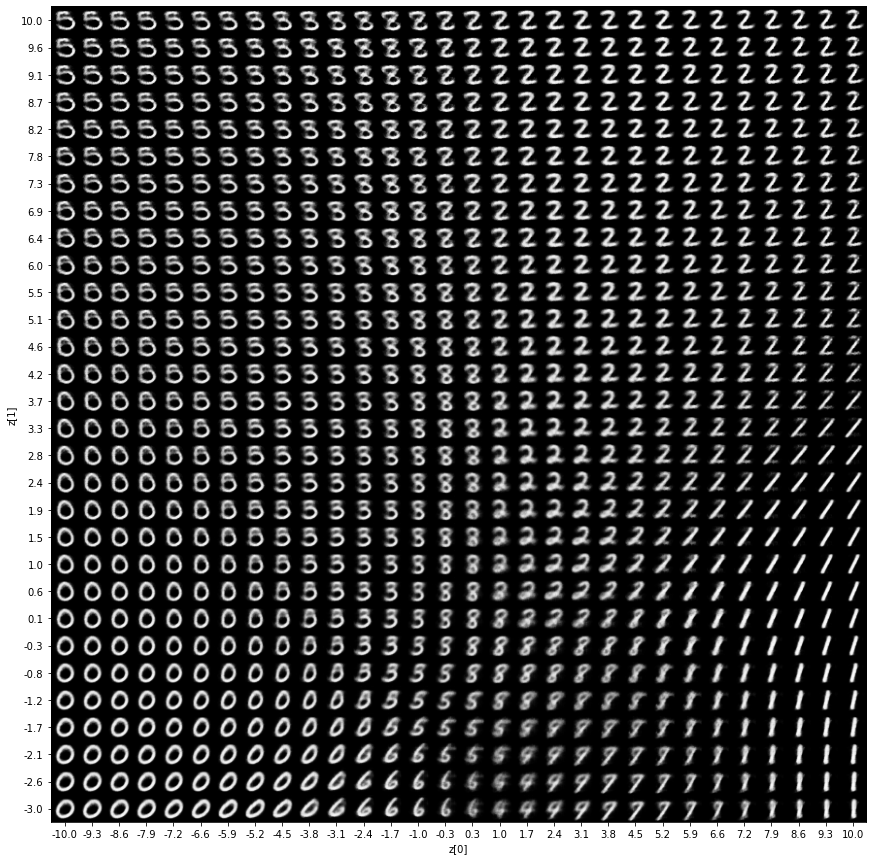

In [11]:
plot_latent_space(decoder, n=30, ranges=[-10, 10, -3, 10], figsize=15)

It looks good! Our autoencoder model successfully embed the input data, and reconstruct the image in self-supervised way.

Next, let's take a look how we can use autoencoder to solve Anomaly Detection problem.

## Anomaly Detection
Now we demonstrated how Autoencoder works, let's utilize this model for anomaly detection purpose.

But why this works for anomaly detection?

Autoencoder learns the patern of data by trying to compress the imformation and resctruct if. So if it is succesfully trained with 'normal' data, it should be able to reconstruct a similar image to 'normal' inputs as we've seen. But if the input was 'anomaly', it won't reconstruct a similar image, since the pattern of anomaly data is very different from normal data.

So in anomaly case, the error between input and output should be larger than nomal case. We can utilize this characteristics of autoencoder for anomaly detection problem.

### Build AutoEncoder for Anomaly Detection

Before actually using autoencoder fot anomaly detection, let's create more performant model by specifying larger latent dimesion.

Larger latent dimension means the model can embed richer infomation in larger space.

In [12]:
def build_autoencoder(latent_dim=8):
    WIDTH, HEIGHT, CHANNEL = (28, 28, 1)  # Size of input data

    encoder = tf.keras.Sequential(
        [
            keras.Input(shape=(WIDTH, HEIGHT, CHANNEL), name="image_input"),
            layers.Conv2D(
                32,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="encoder_convolution_1",
            ),
            layers.Conv2D(
                64,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="encoder_convolution_2",
            ),
            layers.Flatten(name="encoder_flatten"),
            layers.Dense(latent_dim, name="encoder_dense"),
        ],
        name="encoder",
    )

    decoder = tf.keras.Sequential(
        [
            keras.Input(shape=(latent_dim,), name="decoder_input"),
            layers.Dense(7 * 7 * 64, activation="relu", name="decoder_dense"),
            layers.Reshape((7, 7, 64), name="decoder_reshape"),
            layers.Conv2DTranspose(
                32,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="decoder_deconvolution_1",
            ),
            layers.Conv2DTranspose(
                1,
                3,
                activation="sigmoid",
                strides=2,
                padding="same",
                name="decoder_deconvolution_2",
            ),
        ],
        name="decoder",
    )

    autoencoder = tf.keras.Sequential(
        [
            keras.Input(shape=(WIDTH, HEIGHT, CHANNEL), name="image_input"),
            encoder,
            decoder,
        ],
        name="autoencoder",
    )
    autoencoder.build()

    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

    return autoencoder

In [13]:
autoencoder = build_autoencoder(latent_dim=32)  # Speci

In [14]:
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 3s 4ms/step - loss: 0.0453
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0080
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0060
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0048
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0038
Epoch 13/30
547/547 [====

### Detect Anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 

Though the definition of 'Anomaly' depends on cases, in this lab, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than two standard deviation from the training set.


In [15]:
num_sample = 2000  # Number of samples to caliculate threshold

reconstructions = autoencoder.predict(x_train[:num_sample])
train_loss = tf.reduce_mean(
    tf.keras.losses.mae(reconstructions, x_train[:num_sample]), axis=(1, 2)
)

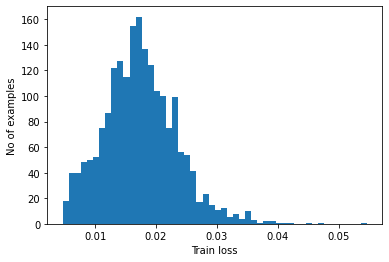

In [16]:
# Visualize histgram of loss value
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Let's choose a threshold value that is two standard deviations above the mean.

In [17]:
# Define Anomaly Threshold
sigma = 2

threshold = np.mean(train_loss) + np.std(train_loss) * sigma
print("Threshold: ", threshold)

Threshold:  0.029600439593195915


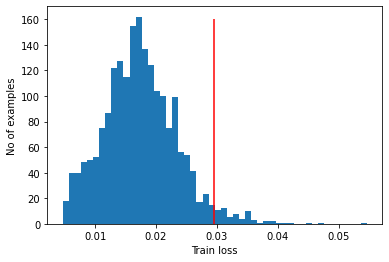

In [59]:
# Visualize histgram of loss value and anomaly threshold
fig = plt.figure()
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.vlines(threshold, 0, 160, color="red")
plt.show()

### Prediction
Prediction should be similar to threshold seting.
1. Call autoencoder and create reconstruction
1. Calicurate Reconstruction Loss
1. Compare and judge if the reconstuction loss is greater than the fixed threshold.

In [18]:
# Detection function
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(
        tf.keras.losses.mae(reconstructions, data), axis=(1, 2)
    )
    return tf.math.greater(loss, threshold), loss[0], reconstructions

This utility function helps us understand the behaviour of autoencoder by visualizing input, reconstructed output, and result of anomaly detection.

In [19]:
# Ploting Utility Function
def plot_reconstruction(model, data, threshold):
    is_anomaly, loss, reconstruction = predict(
        model, tf.expand_dims(data, 0), threshold
    )

    f, axarr = plt.subplots(1, 2)
    lossMSG = f"loss:{loss:.4f}"
    thMSG = f"threshold:{threshold:.4f}"
    text_anomaly = (
        f"Anomaly ({lossMSG} > {thMSG})"
        if is_anomaly
        else f"Normal ({lossMSG} <= {thMSG})"
    )
    title = f.suptitle(text_anomaly)
    c = "r" if is_anomaly else "g"
    plt.setp(title, color=c)

    axarr[0].imshow(data)
    axarr[0].set_title("Original Image")
    axarr[1].imshow(reconstruction[0])
    axarr[1].set_title("Reconstructed Image")
    f.show()

### Let's try to predict on normal data

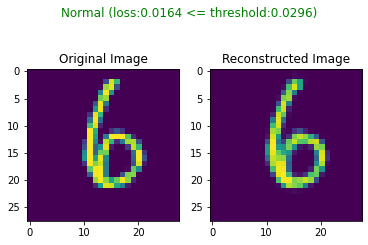

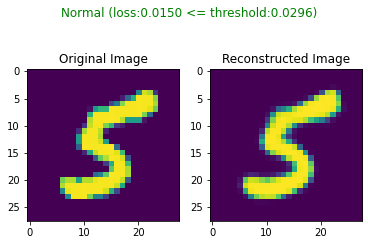

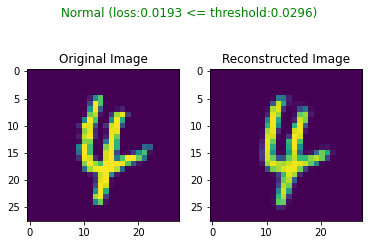

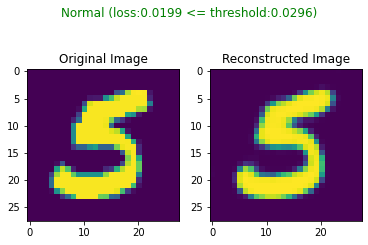

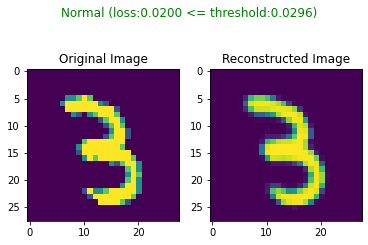

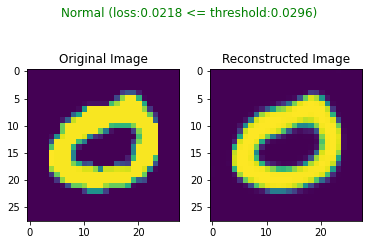

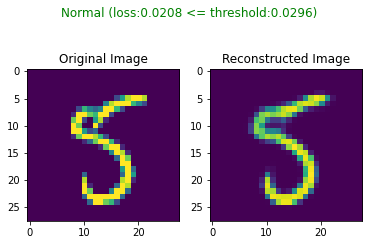

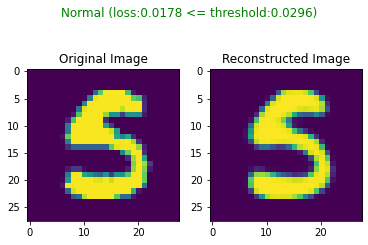

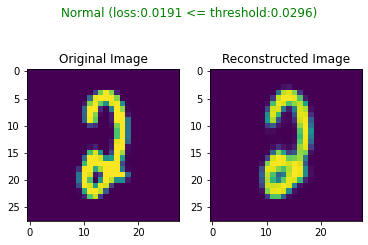

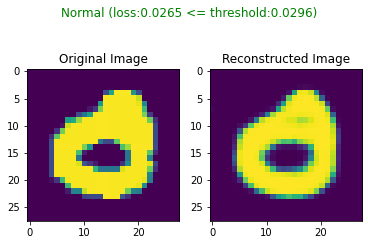

In [20]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, d, threshold)

Looks Like our autoencoder is reconstructing images very well, and the loss value is less than the threshold in most of the cases.<br>
This is what we expected!

### Try Anomaly Data
Then what happens when it get 'unusual' data? Let's create some pertubations below and see what happens.
- 90 degree Rotation
- Negative images
- Noisy images

#### 90 degree Rotation

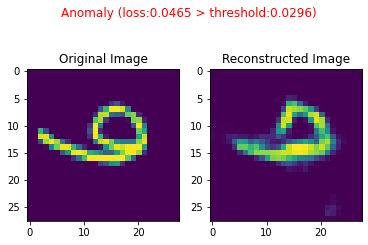

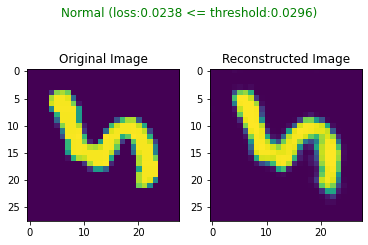

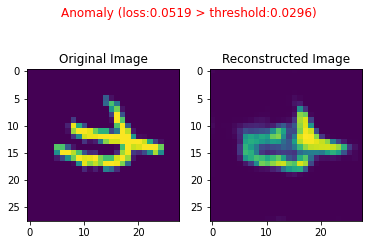

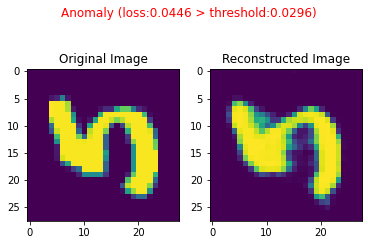

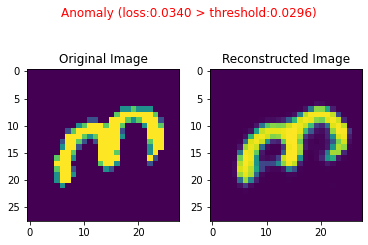

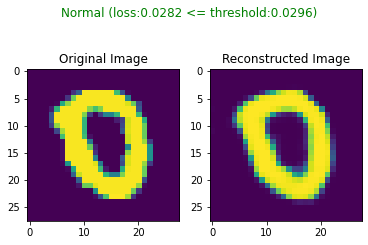

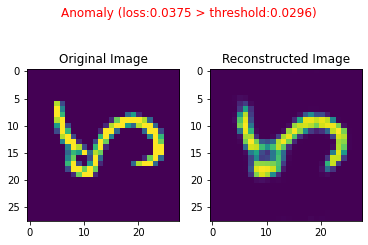

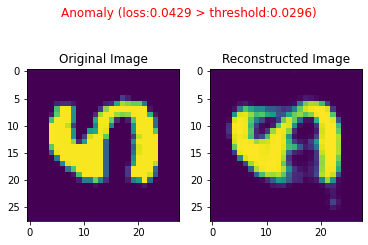

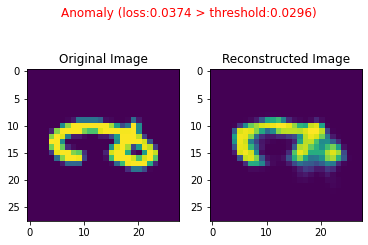

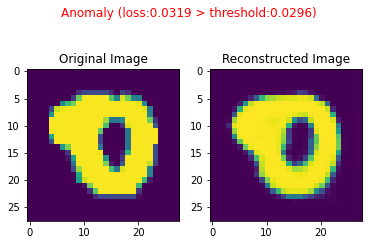

In [21]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, np.rot90(d), threshold)

it looks a lot of rotated images are detected as anomaly, since rotated images are not contained in training and threshold calculation.

But since `0` value is invariable to angles, rotated `0` can be detected as normal.

Next, let's take a look what happens if we create negatives from original image and provide it to our model.

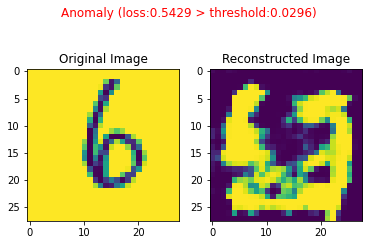

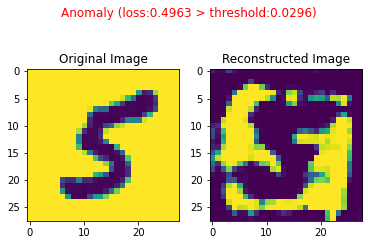

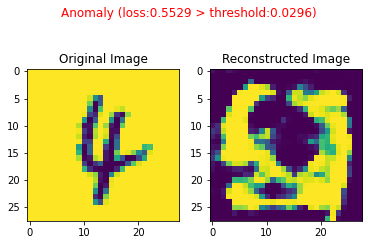

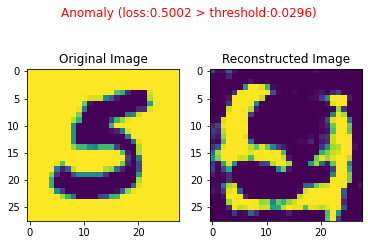

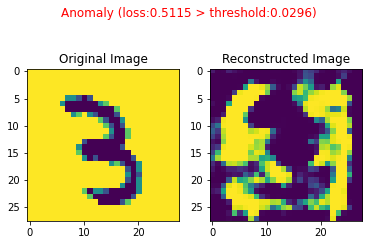

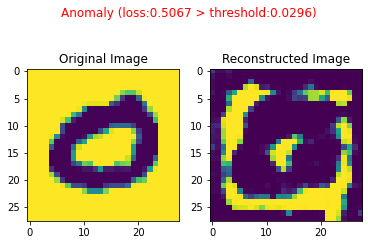

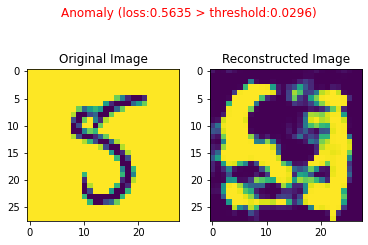

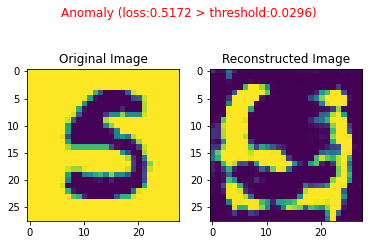

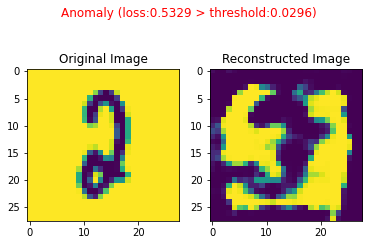

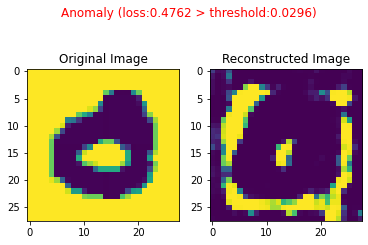

In [22]:
# Negatives
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, 1 - d, threshold)

They are detected as anomaly with large loss value! And we can see our model is not able to construct the original image at all.

Then how about the noisy data?

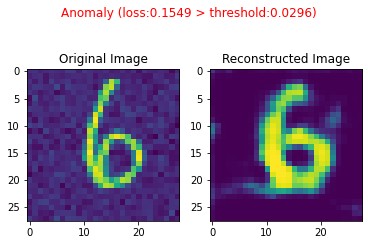

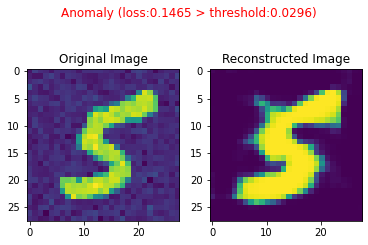

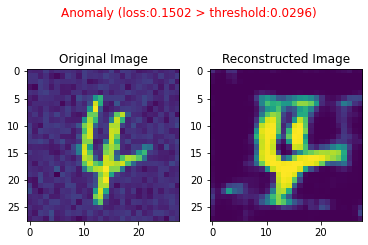

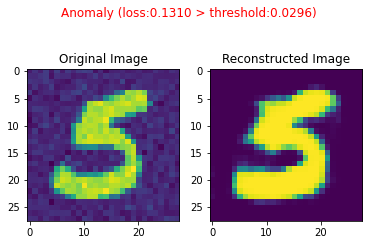

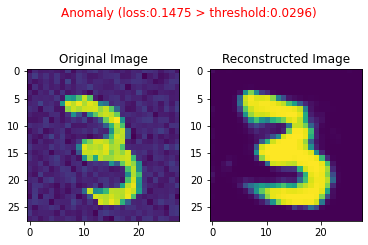

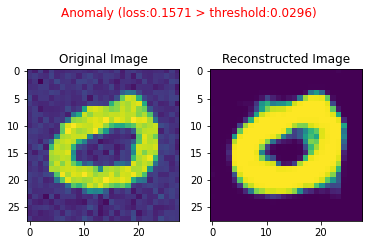

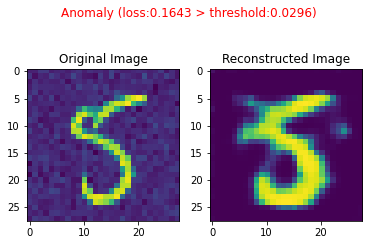

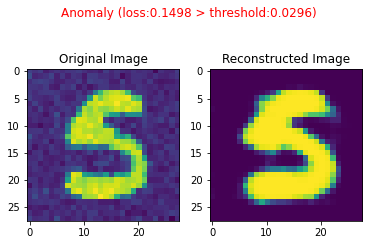

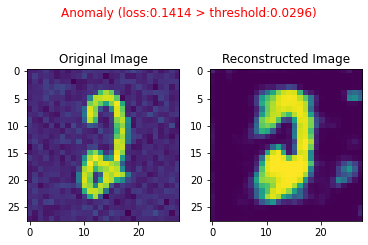

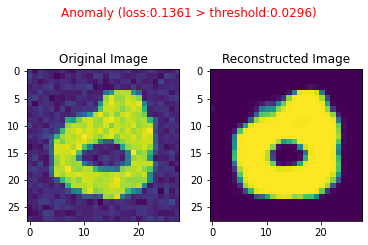

In [23]:
# Add White Noise
def add_noise_and_scale(d):
    noise = np.random.normal(0, 0.05, size=(28, 28, 1))
    _d = d + noise
    return _d - np.min(_d) / (np.max(_d) - np.min(_d))


for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, add_noise_and_scale(d), threshold)

They are also detected as anomaly!

Interestingly, since our autoencoder was trained with clean images, it try to 'denoise' and generate clean images. As a result, the error between input and clean output becomes large, and it detected as anomaly.

Is that mean we can also utilize autoencoders for denoising purpose? Yes we can do it with [denoising autoencoders](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).<br>
But then don't forget to use clean image for training data, to make autoencoders capther the pattern of clean data.



## Summary
In this lab, we learned how to build an autoencoder model, by stacking encoder and decoder.<br>
Also, we learned how to utilize autoencoder for anomaly detection purpose.

# License

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.